# Looking for drift in the Cs-137 spectrum.

The gamma spec resolution is terrible, but it appears (from analogue measurements) that this is due to (effectively) gain variations on the time scale of minutes. This notebook will look at digital data that's been taken to see if by slicing on time we can see these variations.

In [125]:
import tables, json, time
from scipy import stats
from scipy.signal import medfilt, wiener

%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
with open("RunIndex.json", 'r') as fh:
    RunIdx = json.loads(fh.readline())
    
sabrepath = '/data/SABRE/ANU-20170512/'
flist = sorted(RunIdx.keys())

In [129]:
def getQ(wfm,fast=None, returnBL=False):
    '''
    Return the charge in the waveform.
    If 'fast' is given it must be an integer.
    '''
    BG = np.mean(wfm[10:30])
    if fast is None:
        Q = sum(wfm[40:]) - (1024-40)*BG
    else:
        Q = sum(wfm[40:fast]) - (fast-40)*BG
    if not returnBL:
        return Q
    else:
        return Q, BG


In [4]:
#This file is the Cs-137 measurement with the most events.
fname = 'run1494029410.h5'
h5file = tables.open_file(sabrepath+fname, 'r')

#There's probably a more efficient way to do the filtering, but for now I'll do it one wfm at a time...
Nwfms = RunIdx[fname]['Nwfms']
Qmedian = np.array([0.]*Nwfms)
Qmedwien = np.array([0.]*Nwfms)
filt1 = np.array([0.]*1024)
filt2 = np.array([0.]*1024)
Qraw = np.array([0.]*Nwfms)
for i in range(Nwfms):
    filt1 = medfilt(h5file.root.wfms[i,0], kernel_size=7)
    filt2 = wiener(filt1)
    Qmedian[i] = getQ(filt1)
    Qmedwien[i] = getQ(filt2)
    Qraw[i] = getQ(h5file.root.wfms[i,0])

h5file.close()

/scratch3/ljb103/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:946: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
/scratch3/ljb103/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:946: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


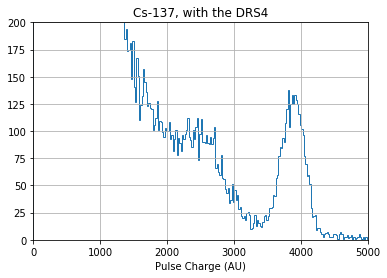

In [97]:
ret = plt.hist(-Qmedwien, bins=500, range=(0,10000), histtype='step')
#plt.yscale('log')
plt.ylim(0,200)
plt.xlabel('Pulse Charge (AU)')
plt.title('Cs-137, with the DRS4')
plt.xlim(0,5000)
plt.grid()
plt.gcf().savefig('CsSpec_digital.png')

Chi2 = 1.1899192564798013


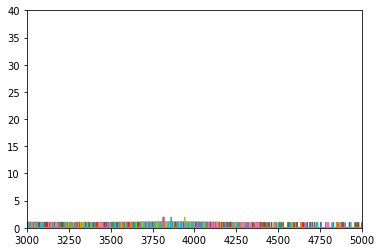

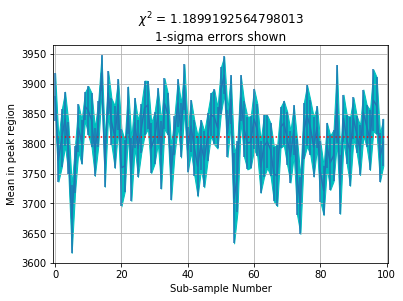

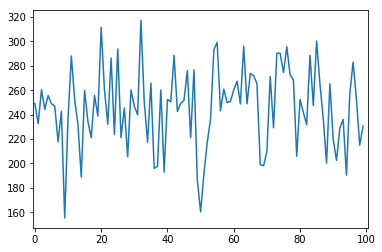

In [123]:
#now let's slice up the spectrum:
fig = plt.figure()
Nslices = 100
means = np.empty(Nslices, dtype=float)
Umeans = np.empty(Nslices, dtype=float)
sigmas = np.empty(Nslices, dtype=float)
for i in range(Nslices):
    startidx = int(i*(len(Qmedwien)/Nslices))
    increment = int(len(Qmedwien)/Nslices)-1
    ret = plt.hist(-Qmedwien[startidx:startidx+increment], bins=100000, range=(0,10000), histtype='step')
    theslice = slice(int(len(ret[1])*(3100./10000)),int(len(ret[1])*(4500./10000)))
    themean = sum(ret[0][theslice]*ret[1][theslice])/sum(ret[0][theslice])
    thesqmean = sum(ret[0][theslice]*ret[1][theslice]**2)/sum(ret[0][theslice])
    thestd = np.sqrt(thesqmean - themean**2)
    theESDM = thestd/np.sqrt(sum(ret[0][theslice]))
    #print('mean = {0} +/- {1}, std = {2}'.format(themean, theESDM, thestd))
    means[i] = themean
    Umeans[i] = theESDM
    sigmas[i] = thestd
    
#plt.yscale('log')
plt.xlim(3000,5000)
plt.ylim(0, 40)
fig = plt.figure()
plt.fill_between(range(Nslices), means-Umeans, means+Umeans, color='c')
plt.errorbar(range(Nslices), means, yerr=Umeans)
plt.xlim(-0.5, Nslices+0.5)
plt.hlines(avgmean, -0.5, Nslices+0.5, 'r', linestyles=':')
plt.grid()
plt.xlabel('Sub-sample Number')
plt.ylabel('Mean in peak region')
avgmean = np.mean(means)
plt.title('$\chi^2$ = {0}\n1-sigma errors shown'.format(sum((avgmean - means)**2/Umeans**2)/len(means-1)))
plt.gcf().savefig('CsPeak_variability.png', )
fig = plt.figure()
plt.plot(range(Nslices), sigmas)
plt.xlim(-0.5, Nslices+0.5)

print('Chi2 = {0}'.format(sum((avgmean - means)**2/Umeans**2)/len(means-1)))

Not really significant (1.2 sigma) deviations from a flat distribution, and there appears to be some correlations in the mean location (could do a runs test to check).

# Sensor-correlated Cs-137 Data

We took measurements for a couple of hours with the Cs-137 source and the digitizer; with the sensor board running concurrently. I want to do a similar analysis where I slice it up by time, then do another analysis where I look at the peak location as a funtion of the environmental parameters.

In [130]:
extrapath = '/data/SABRE/BenchMeasurements/Katrina/'
extrafilebase = 'run1496296002'
wfmfile = tables.open_file(extrapath+extrafilebase+'.h5', 'r')

#There's probably a more efficient way to do the filtering, but for now I'll do it one wfm at a time...
Nwfms = len(wfmfile.root.wfms)
filt1 = np.empty(1024, dtype=np.float64)
filt2 = np.empty(1024, dtype=np.float64)
Q2median = np.empty(Nwfms, dtype=np.float64)
Q2medwien = np.empty(Nwfms, dtype=np.float64)
Q2raw = np.empty(Nwfms, dtype=np.float64)
BLmedian = np.empty(Nwfms, dtype=np.float64)
BLmedwien = np.empty(Nwfms, dtype=np.float64)
BLraw = np.empty(Nwfms, dtype=np.float64)
Q2tstamp = np.empty(Nwfms, dtype=np.float64)
for i in range(Nwfms):
    filt1 = medfilt(wfmfile.root.wfms[i,1], kernel_size=7)
    filt2 = wiener(filt1)
    BLmedian[i], Q2median[i] = getQ(filt1, returnBL=True)
    BLmedwien[i], Q2medwien[i] = getQ(filt2, returnBL=True)
    BLraw[i], Q2raw[i] = getQ(wfmfile.root.wfms[i,1], returnBL=True)
    Q2tstamp = wfmfile.root.unixtime[i]

wfmfile.close()


/scratch3/ljb103/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:946: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
/scratch3/ljb103/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:946: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


-974.35190389631589

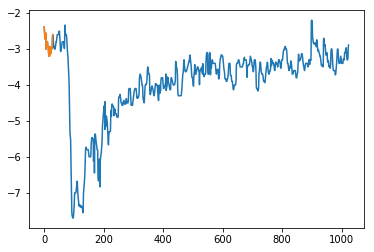

In [124]:
plt.plot(range(len(filt2)), filt2)
plt.plot(range(len(filt2[0:30])), filt2[0:30])
Q2medwien[-1]

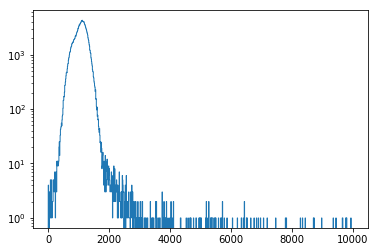

In [53]:
ret = plt.hist(-Q2medwien, bins=1000, range=(0,10000), histtype='step')
plt.yscale('log')

Chi2 = 4.218916571673365


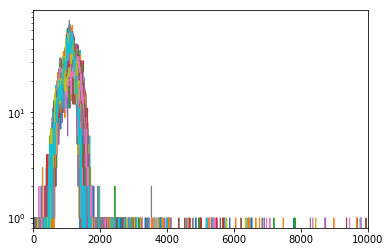

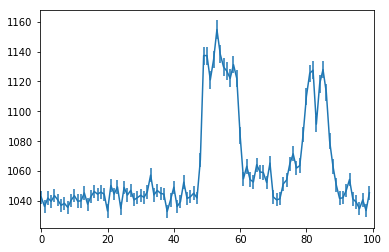

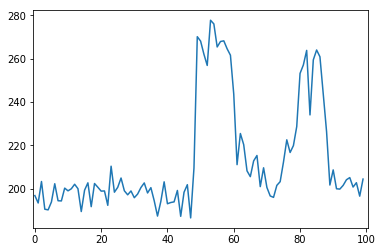

In [73]:
#now let's slice up the spectrum:
fig = plt.figure()
Nslices = 100
means2 = np.empty(Nslices, dtype=float)
Umeans2 = np.empty(Nslices, dtype=float)
sigmas2 = np.empty(Nslices, dtype=float)
for i in range(Nslices):
    startidx = int(i*(len(Q2medwien)/Nslices))
    increment = int(len(Q2medwien)/Nslices)-1
    ret = plt.hist(-Q2medwien[startidx:startidx+increment], bins=1000, range=(0,10000), histtype='step')
    theslice = slice(int(len(ret[1])*(100./10000)),int(len(ret[1])*(3000./10000)))
    themean = sum(ret[0][theslice]*ret[1][theslice])/sum(ret[0][theslice])
    thesqmean = sum(ret[0][theslice]*ret[1][theslice]**2)/sum(ret[0][theslice])
    thestd = np.sqrt(thesqmean - themean**2)
    theESDM = thestd/np.sqrt(sum(ret[0][theslice]))
    #print('mean = {0} +/- {1}, std = {2}'.format(themean, theESDM, thestd))
    means2[i] = themean
    Umeans2[i] = theESDM
    sigmas2[i] = thestd
    
plt.yscale('log')
plt.xlim(0.,10000)
#plt.ylim(0, 40)
fig = plt.figure()
plt.errorbar(range(Nslices), means2, yerr=Umeans2)
plt.xlim(-0.5, Nslices+0.5)
fig = plt.figure()
plt.plot(range(Nslices), sigmas2)
plt.xlim(-0.5, Nslices+0.5)

avgmean2 = np.mean(means2)
print('Chi2 = {0}'.format(sum((avgmean2 - means2)**2/sigmas2)/len(means2-1)))

In [21]:
#Now get the environmental data
envfile = tables.open_file(extrapath+extrafilebase+'_env.h5', 'r')
envfile.root

/ (RootGroup) ''
  children := ['TPH' (Table), 'rundata' (Table), 'vibrate' (Table)]

In [23]:
envfile.root.TPH.shape

(3353,)

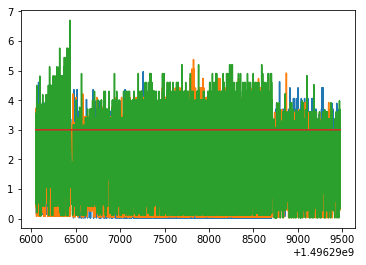

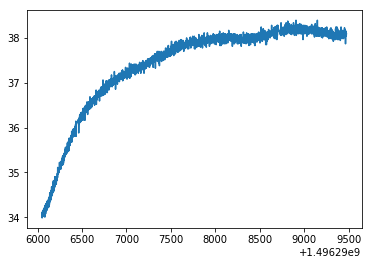

In [35]:
fig = plt.figure()
vib_thr_sigma = envfile.root.rundata[:]['vibr_threshold']
x_BL = envfile.root.rundata[:]['vibr_BL_x']
y_BL = envfile.root.rundata[:]['vibr_BL_y']
z_BL = envfile.root.rundata[:]['vibr_BL_z']
Ux_BL = envfile.root.rundata[:]['Uvibr_BL_x']
Uy_BL = envfile.root.rundata[:]['Uvibr_BL_y']
Uz_BL = envfile.root.rundata[:]['Uvibr_BL_z']
cal_ends = envfile.root.rundata[:]['calend']

calmask = np.empty(len(envfile.root.vibrate), dtype=int)
sigthr = np.empty(len(envfile.root.vibrate), dtype=np.float64)
nsigma_x = np.empty(len(envfile.root.vibrate), dtype=np.float64)
nsigma_y = np.empty(len(envfile.root.vibrate), dtype=np.float64)
nsigma_z = np.empty(len(envfile.root.vibrate), dtype=np.float64)
for i, val in enumerate(envfile.root.vibrate):
    tdiff = val['unixtime']-cal_ends
    calidx = np.argmin(tdiff[tdiff>0])
    calmask[i] = calidx
    sigthr[i] = vib_thr_sigma[calidx]
    nsigma_x[i] = np.abs(val['x']-x_BL[calidx])/Ux_BL[calidx]
    nsigma_y[i] = np.abs(val['y']-y_BL[calidx])/Uy_BL[calidx]
    nsigma_z[i] = np.abs(val['z']-z_BL[calidx])/Uz_BL[calidx]
    
plt.plot(envfile.root.vibrate[:]['unixtime'], nsigma_x)
plt.plot(envfile.root.vibrate[:]['unixtime'], nsigma_y)
plt.plot(envfile.root.vibrate[:]['unixtime'], nsigma_z)
plt.plot(envfile.root.vibrate[:]['unixtime'], sigthr)

fig = plt.figure()
plt.plot(envfile.root.TPH[:]['unixtime'], envfile.root.TPH[:]['T'])

(0, 10000)

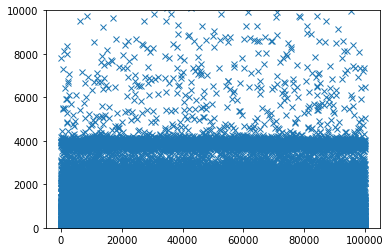

In [52]:
plt.plot(range(len(Qmedwien)), -Qmedwien, 'x')
plt.ylim(0,10000)

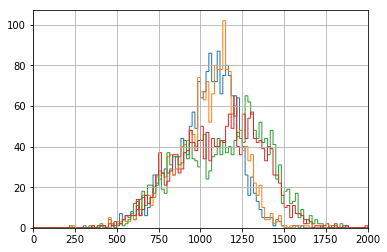

In [70]:
thesliceno = 0
startidx = int(0*(len(Q2median)/Nslices))
increment = int(len(Q2median)/Nslices)-1
ret = plt.hist(-Q2raw[startidx:startidx+increment], bins=600, range=(0,10000), histtype='step')
ret = plt.hist(-Q2median[startidx:startidx+increment], bins=600, range=(0,10000), histtype='step')

thesliceno = 55
startidx = int(thesliceno*(len(Q2median)/Nslices))
increment = int(len(Q2median)/Nslices)-1
ret = plt.hist(-Q2median[startidx:startidx+increment], bins=600, range=(0,10000), histtype='step')

thesliceno = 80
startidx = int(thesliceno*(len(Q2median)/Nslices))
increment = int(len(Q2median)/Nslices)-1
ret = plt.hist(-Q2median[startidx:startidx+increment], bins=600, range=(0,10000), histtype='step')

plt.xlim(0,2000)
plt.grid()

In [65]:
((250))/(1100)

0.22727272727272727

Well, I don't understand what I'm looking at! Clearly, there's some variation in the peak locations. But because I can't see a Compton edge I can't be sure of what I'm looking at. We should re-take these data...

# MCA measurements

- Re-took data with back-to-back 1 minute acquisitions, Cs-137.
- Let's analyse these...

Chi2 = 4.833006011177321


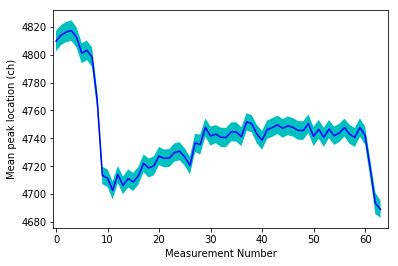

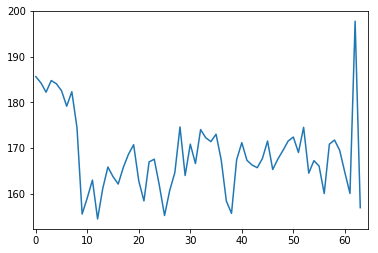

In [140]:
mydata = np.fromfile('/home/ljb103/NeutronSpec/BenchTests/MCAdata/Cs137_test_005.asc', dtype=int, sep=' ')
mcadata = mydata.reshape((64,8192))
mcameans = np.empty(mcadata.shape[0], dtype=float)
mcaUmeans = np.empty(mcadata.shape[0], dtype=float)
mcasigmas = np.empty(mcadata.shape[0], dtype=float)
for i, spec in enumerate(mcadata):
    #ret = plt.hist(-Q2medwien[startidx:startidx+increment], bins=1000, range=(0,10000), histtype='step')
    lowcut = 4000
    highcut = 5500
    theslice = slice(lowcut,highcut)
    chvals = np.linspace(lowcut, highcut-1, highcut-lowcut)
    mcameans[i] = sum(spec[theslice]*chvals)/sum(spec[theslice])
    thesqmean = sum(spec[theslice]*chvals**2)/sum(spec[theslice])
    mcasigmas[i] = np.sqrt(thesqmean - mcameans[i]**2)
    mcaUmeans[i] = mcasigmas[i]/np.sqrt(sum(spec[theslice]))
    
#plt.yscale('log')
#plt.xlim(0.,10000)
#plt.ylim(0, 40)
fig = plt.figure()
plt.plot(range(mcadata.shape[0]), mcameans, 'b')
plt.fill_between(range(mcadata.shape[0]), mcameans - 1.96*mcaUmeans, mcameans + 1.96*mcaUmeans, facecolor='c')
plt.xlim(-0.5, mcadata.shape[0]+0.5)
plt.xlabel('Measurement Number')
plt.ylabel('Mean peak location (ch)')
plt.savefig('/home/ljb103/NeutronSpec/BenchTests/MCAdata/test5_Meanplot.png', dpi=200)
fig = plt.figure()
plt.plot(range(mcadata.shape[0]), mcasigmas)
plt.xlim(-0.5, mcadata.shape[0]+0.5)

avgmcamean = np.mean(mcameans)
print('Chi2 = {0}'.format(sum((avgmcamean - mcameans)**2/mcasigmas)/len(mcameans-1)))

In [138]:
mcasigmas

array([ 185.65542121,  184.28029055,  182.24821626,  184.79390699,
        184.09060004,  182.55349058,  179.17550028,  182.34461568,
        174.49789931,  155.56495311,  159.10226149,  163.00050516,
        154.49895565,  161.12914509,  165.86503128,  163.75163532,
        162.13414446,  165.78351472,  168.66688002,  170.74089579,
        162.80863004,  158.44683597,  166.97919682,  167.57412056,
        161.77770804,  155.24612768,  160.70376602,  164.64508067,
        174.63402744,  164.0050416 ,  170.86419989,  166.62579704,
        174.0626836 ,  172.26146298,  171.42962412,  173.04241415,
        167.42895729,  158.40186231,  155.71554553,  167.47144094,
        171.19681295,  167.3201759 ,  166.29230545,  165.71484575,
        167.72237218,  171.54800201,  165.31008657,  167.60241579,
        169.51074728,  171.54632182,  172.4226983 ,  169.04373411,
        174.54510828,  164.51983014,  167.2556479 ,  166.07682838,
        160.05779879,  170.86058666,  171.76872021,  169.52567

/scratch3/ljb103/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  This is separate from the ipykernel package so we can avoid doing imports until
/scratch3/ljb103/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  after removing the cwd from sys.path.
/scratch3/ljb103/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  """


Chi2 = 4.099279406052906


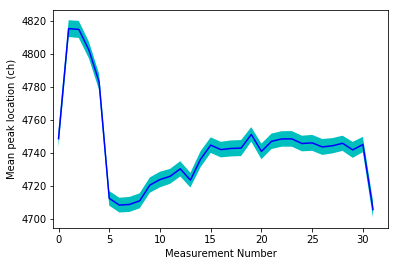

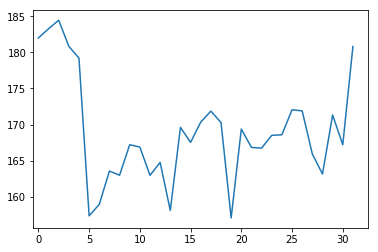

In [143]:
mydata = np.fromfile('/home/ljb103/NeutronSpec/BenchTests/MCAdata/Cs137_test_005.asc', dtype=int, sep=' ')
mcadata = mydata.reshape((64,8192))
mcameans2 = np.empty(mcadata.shape[0]/2, dtype=float)
mcaUmeans2 = np.empty(mcadata.shape[0]/2, dtype=float)
mcasigmas2 = np.empty(mcadata.shape[0]/2, dtype=float)
for i in range(int(len(mcadata)/2)):
    #ret = plt.hist(-Q2medwien[startidx:startidx+increment], bins=1000, range=(0,10000), histtype='step')
    lowcut = 4000
    highcut = 5500
    theslice = slice(lowcut,highcut)
    chvals = np.linspace(lowcut, highcut-1, highcut-lowcut)
    thisspec = mcadata[i*2] + mcadata[i*2 - 1]
    mcameans2[i] = sum(thisspec[theslice]*chvals)/sum(thisspec[theslice])
    thesqmean = sum(thisspec[theslice]*chvals**2)/sum(thisspec[theslice])
    mcasigmas2[i] = np.sqrt(thesqmean - mcameans2[i]**2)
    mcaUmeans2[i] = mcasigmas2[i]/np.sqrt(sum(thisspec[theslice]))
    
#plt.yscale('log')
#plt.xlim(0.,10000)
#plt.ylim(0, 40)
fig = plt.figure()
plt.plot(range(int(mcadata.shape[0]/2)), mcameans2, 'b')
plt.fill_between(range(int(mcadata.shape[0]/2)), mcameans2 - 1.96*mcaUmeans2, mcameans2 + 1.96*mcaUmeans2, facecolor='c')
plt.xlim(-0.5, (mcadata.shape[0]/2)+0.5)
plt.xlabel('Measurement Number')
plt.ylabel('Mean peak location (ch)')
#plt.savefig('/home/ljb103/NeutronSpec/BenchTests/MCAdata/test5_Meanplot.png', dpi=200)
fig = plt.figure()
plt.plot(range(int(mcadata.shape[0]/2)), mcasigmas2)
plt.xlim(-0.5, (mcadata.shape[0]/2)+0.5)

avgmcamean = np.mean(mcameans2)
print('Chi2 = {0}'.format(sum((avgmcamean - mcameans2)**2/mcasigmas2)/len(mcameans2-1)))

In [146]:
170/4720

0.036016949152542374